# Support Vector Machines

In machine learning, support vector machines (SVMs) are supervised learning models with associated learning algorithms that analyze data for classification and regression analysis. But, it's used widely in classification objectives (SVC), and that's what we'll be aiming at in this notebook. The support vector classifier algorithm intends to find a hyperplane in N_dimensional space (N is the number of features) that distinctly classifies the data points into two separate classes.

To separate two classes of data points, many possible hyperplanes could be selected. Our objective is to find a plane with the maximum margin, i.e., the maximum distance between data points of both classes using SVC.


### Learning goals:
- Understand the math behind SVC and implement it from scratch
- Separate linearly separable data points
- Implement __soft margin calssifier__, that is maximize the margin but allow some samples within the margin when classes are not linearly separable
- Implement __kernel trick__ to separate nonlinearly separable data points using nonlinear kernels

### References

- [1] [Stanford CS229 Machine Learning](https://www.youtube.com/playlist?list=PLoROMvodv4rMiGQp3WXShtMGgzqpfVfbU), [CS229 lecture notes](http://cs229.stanford.edu/syllabus.html)
- [2] [Seyed Naser Razavi's machine learning class](https://www.youtube.com/playlist?list=PLW529xl11jnnupZKT5Og4pwHPoRFQRQz_) (Persian)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as pltcolors
from sklearn import svm
from sklearn.datasets import make_circles
from scipy import optimize

# Helpers

Helpers for plotting

In [2]:
def plotLine(ax, xRange, w, x0, label, color='grey', linestyle='-', alpha=1.):
    """ Plot a (separating) line given the normal vector (weights) and point of intercept """
    if type(x0) == int or type(x0) == float or type(x0) == np.float64:
        x0 = [0, -x0 / w[1]]
    yy = -(w[0] / w[1]) * (xRange - x0[0]) + x0[1]
    ax.plot(xRange, yy, color=color, label=label, linestyle=linestyle)
    

    
def plotSvm(X, y, supportVectors=None, w=None, intercept=0., label='Data', separatorLabel='Separator', 
            ax=None, bound=[[-1., 1.], [-1., 1.]]):
    """ Plot the SVM separation, and margin """
    if ax is None:
        fig, ax = plt.subplots(1)
    
    im = ax.scatter(X[:,0], X[:,1], c=y, cmap=cmap, alpha=0.5, label=label)
    
    if supportVectors is not None:
        ax.scatter(supportVectors[:,0], supportVectors[:,1], label='SupportVector', s=80, facecolors='none', 
                   edgecolors='gold', color='gold')
        print(f"Number of support vectors = {len(supportVectors)}" )
        
    if w is not None:
        xx = np.array(bound[0])
        plotLine(ax, xx, w, intercept, separatorLabel) # Plotting the optimal margin
        # Plotting the positive and negative margins
        if supportVectors is not None:
            signedDist = np.matmul(supportVectors, w)
            margin = 2. / np.linalg.norm(w) # M = 2. / ||w||
            
            supportMaxNeg = supportVectors[np.argmin(signedDist)]
            supportMaxPos = supportVectors[np.argmax(signedDist)]
            
            plotLine(ax, xx, w, supportMaxNeg, 'Margin -', linestyle='-.', alpha=0.8)
            plotLine(ax, xx, w, supportMaxPos, 'Margin +', linestyle='--', alpha=0.8)
            ax.set_title('Margin = %.3f' % (margin))
            
    ax.legend(loc='upper left')
    ax.grid()
    ax.set_xlim(bound[0])
    ax.set_ylim(bound[1])
    loc = np.arange(-1,1,1)

## The data model
We'll use a simple model with two Gaussians that are faraway in order to be separable.

In [3]:
colors = ['blue','red']
cmap = pltcolors.ListedColormap(colors)
nFeatures = 2
N = 100

def generateBatchBipolar(n, mu=0.5, sigma=0.2):
    """ Two gaussian clouds on each side of the origin """
    X = np.random.normal(mu, sigma, (n, nFeatures))
    # yB in {0, 1}
    yB = np.random.uniform(0, 1, n) > 0.5
    # y is in {-1, 1}
    y = 2. * yB - 1
    X *= y[:, np.newaxis]
    X -= X.mean(axis=0)
    return X, y

Let's get started.
## 1.Maximum Margin Classifier
The following explanation is about the binary classification but can be generalized to more classes.

Let $X$ be the matrix of $n$ samples of the $p$ features. We want to separate the two classes of $y$ with an hyperplan (a straight line in 2D, that is $p=2$). The separation equation is:

$$ w^T x + b = 0, w \in \mathbb{R}^{p}, x \in \mathbb{R}^{p}, b \in \mathbb{R} $$


If _x̂_ (a sample), happens to lie above the hyperplane, we'll get: 
$$w^T x̂^+ + b > 0 \tag{1}$$ 

and if it happens to lie below the hyperplane, we'll get: 
$$w^T x̂^- + b < 0 \tag{2}$$

Let's define $ŷ$ as the corresponding label of $x̂$, such that $ŷ \in \{-1, 1\}$(-1 if below hyperplane and 1 if above hyperplane), then: 

$$ŷ(w^T x̂ + b) > 0 \tag{3}$$

The equation _$\hat{\gamma}_i = y_i(w^T x_i + b)$_ is called __the functional margin__ of the sample $(x_i, y_i)$.

Another variable that we'll be using is $\gamma_i = \frac{\hat{\gamma}_i}{\Vert w \Vert}$, which is the unsigned euclidean distance of sample $(x_i, y_i)$ from the hyperplane (or __the geometric margin__).

Let's define $\gamma$ as follows:  
$$\gamma = \underset{i=1,...,n}{\min} \gamma_i = \frac{\hat{\gamma}_i}{\Vert w \Vert} = \frac{y_i(w^T x_i + b)}{\Vert w \Vert}\tag{4}$$

__The Maximum Margin Classifier__ aims at maximizing _$\gamma$_ such that:

$$ \underset{w, b}{\max} \gamma $$
__Subject to:__
- $\frac{y_i(w^T x_i + b)}{\Vert w \Vert} \ge \gamma, i\in {1,...,n}$

In other words, maximize the smallest distance from the hyperplane.

Now if we let $\gamma = \frac{1}{\Vert w \Vert}$, then we'll get:

$${\max} \frac{1}{\Vert w \Vert}$$
__Subject to:__
- $y_i(w^T x_i + b) \ge 1, i \in {1,...,n}$

An equivalent to maximizing $\frac{1}{\Vert w \Vert}$ is minimizing $ \frac{1}{2}\Vert w \Vert^2$ (smaller $w$ means bigger margin). thus we can say:

$${\min} \frac{1}{2}\Vert w \Vert^2$$
__S.t. :__
- $y_i(w^T x_i + b) \ge 1, i \in {1,...,n}$

Thus, we can find $w$ and $b$ of the maximum margin classifier by minimizing:
$$\mathcal{L}_p(w, b, \alpha) = \frac{1}{2}\Vert w \Vert^2 - \sum_{i=1}^n\alpha_i(y_i(w^T x_i + b) - 1)\tag{5}$$
__S.t. :__

- $\alpha_i \ge 0, i\in 1,...,n$

$\mathcal{L}_p(w, b, \alpha)$ is called __the Lagrange Primal problem__. This shall be __minimized__ on $w$ and $b$, using the corresponding partial derivates equal to 0, we get: 
$$\begin{align}
& w = \sum_{i=1}^n \alpha_i y_i x_i \tag{6}\\
& \sum_{i=1}^n \alpha_i y_i = 0 \tag{7}\\
\end{align}$$

By replacing them in the __Primal problem__, we get __the Dual problem__:

$$\begin{align}
\mathcal{L}_d (\alpha)
&= \sum_{i=1}^n \alpha_i - \frac {1}{2} \sum_{i=1}^n \sum_{j=1}^n \alpha_i \alpha_j y_i y_j x_i^T x_j \\
&= \sum_{i=1}^n \alpha_i - \frac {1}{2} \sum_{i=1}^n \sum_{j=1}^n \langle \alpha_i y_i x_i, \alpha_j y_j x_j \rangle \tag{8} \\
& (-\frac 12 \Vert  w \Vert^2 = -\frac {1}{2} \sum_{i=1}^n \sum_{j=1}^n \langle \alpha_i y_i x_i, \alpha_j y_j x_j\rangle)
\end{align}$$
Which shall be __maximized__ on $\alpha$ (since we want to minimize  $\frac 12 \Vert w \Vert^2$ and $w = \sum_{i=1}^n \alpha_i y_i x_i$ (6)) subject to:

- $\alpha_i \ge 0, i\in 1,...,n$
- $\sum_{i=0}^n \alpha_i y_i = 0, i\in 1,...,n$

This is a hard problem, thus we'll use an optimizer to find it's maximum. Then, we'll calculate $w$ using the equation (6) and $b$ using the equation below:

$$ b = - \frac{\underset{i:y_i=-1}\max w^T x_i + \underset{i:y_i=1}\min w^T x_i}{2}, i \in 1,...,n \tag{9}$$


And finally, for classifying a new sample like $x_{new}$, we'll just return $y_{new} = sign(w^T x_{new} + b)$.

## Train data

To demonstrate the maximum margin classifier, a dataset with separable classes is required. Let's use a mixture of two gaussian distributed classes with mean and variance such that the two classes are separated.

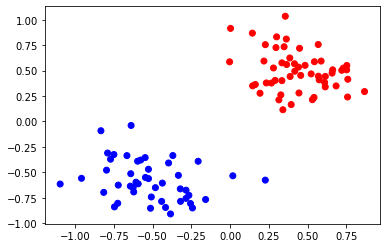

In [4]:
X, y = generateBatchBipolar(N, mu=.5, sigma=.22)

plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap)

## Implementation of the Maximum margin Classifier

The classifier is built on the __scipy.optimize.minimum__ solver.
For more info visit: https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html#scipy.optimize.minimize

In [5]:
class MaxMarginClassifier:
    
    def __init__(self):
        self.alpha = None
        self.w = None
        self.supportVectors = None
    
    def fit(self, X, y):
        N = len(y)
        yX = y[:, np.newaxis] * X # yX
        
        # Gram matrix of (yX)
        GramyX = np.matmul(yX, yX.T)
        
        # Lagrange dual problem
        def Ld(G, alpha):
            return alpha.sum() - 0.5 * alpha.dot(alpha.dot(G)) # equation 8

        # Partial derivate of Ld on alpha
        def LdAlpha(G, alpha):
            return np.ones_like(alpha) - alpha.dot(G)

        # Constraints on alpha:
        # 1.sum (alpha_i*y_i) = 0 for i in {1,...,n}
        # 2.aplha_i >= 0 for i in {1,...,n}
        I = np.eye(N)
        constraints = ({'type': 'eq',   'fun': lambda a: np.dot(a, y), 'jac': lambda a: y},
                       {'type': 'ineq', 'fun': lambda a: np.dot(I, a), 'jac': lambda a: I})

        # Maximizing by 'Minimizing' the opposite
        optRes = optimize.minimize(fun=lambda a: -Ld(GramyX, a),
                                   x0=np.zeros(N), 
                                   method='SLSQP', 
                                   jac=lambda a: -LdAlpha(GramyX, a), 
                                   constraints=constraints)
        self.alpha = optRes.x
        self.w = np.sum((self.alpha[:, np.newaxis] * yX), axis=0) # equation 6
        epsilon = 1e-6
        self.supportVectors = X[self.alpha > epsilon]
        
        # Support vectors are at a distance <= 1 to the separation hyperplane
        negSupportVec = max(np.dot(self.supportVectors[np.dot(self.supportVectors, self.w) < 0], self.w))
        posSupportVec = min(np.dot(self.supportVectors[np.dot(self.supportVectors, self.w) >= 0], self.w))
        self.intercept = -(negSupportVec + posSupportVec)/2 # equation 9

        
    def predict(self, X):
        """ Predict y value in {-1, 1} """
        assert(self.w is not None)
        assert(self.w.shape[0] == X.shape[1])
        return 2 * (np.matmul(X, self.w) > 0) - 1

In [6]:
model = MaxMarginClassifier()
model.fit(X, y)
model.w, model.intercept

(array([1.62831635, 2.62342076]), 0.1440287974237192)

Number of support vectors = 3


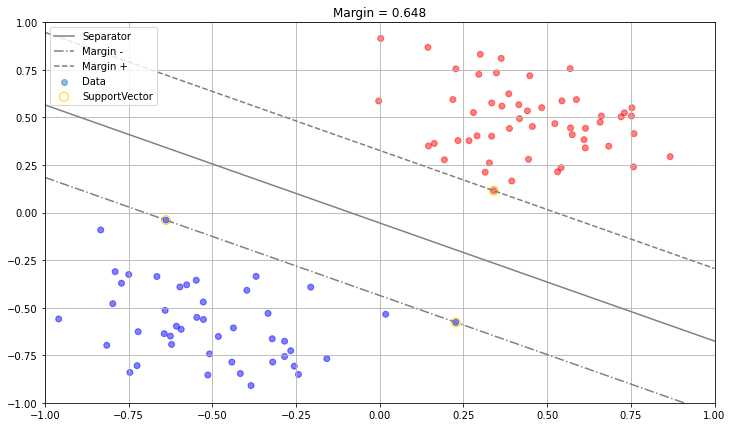

In [7]:
fig, ax = plt.subplots(1, figsize=(12, 7))
plotSvm(X, y, model.supportVectors, model.w, model.intercept, ax=ax)

## Training the model using sklearn.svm.SVC

In [8]:
SKmodel = svm.SVC(kernel='linear', gamma='auto', C = 1e6)
SKmodel.fit(X, y)
SKmodel.coef_[0], SKmodel.intercept_[0]

(array([1.62880536, 2.62420841]), 0.1441721789786716)

Number of support vectors = 3


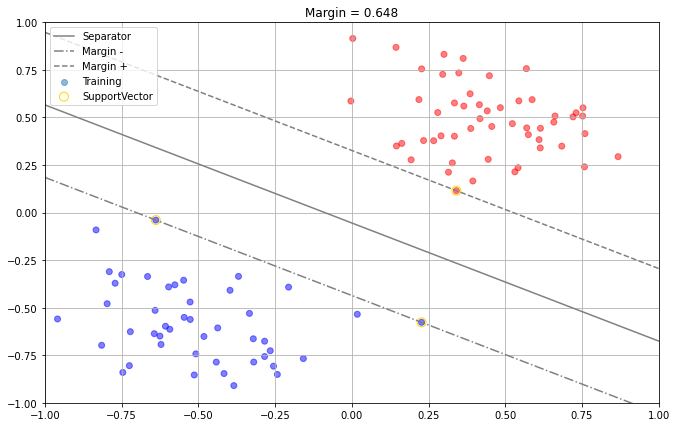

In [9]:
fig, ax = plt.subplots(1, figsize=(11, 7))
plotSvm(X, y, SKmodel.support_vectors_, SKmodel.coef_[0], SKmodel.intercept_[0], 
        label='Training', ax=ax)

## 2. Soft Margin Classifier
The example above has little interest as the separation is trivial.

Using the exact SVC implementation on a _nonseparable_ or _linearly not separable_ case would be impossible, the solver would fail.

Here comes the soft margin: some $x_i$s are allowed to lie between the two margin bars.

The Soft margin classifier is adding a regularization parameter in minimizing $\frac 12 \Vert w \Vert^2$:

$$\underset{w, b}{\min} \frac 12 \Vert w \Vert^2 + C\sum_{i=1}^n \xi_i \tag{10}$$

__S.t.__ :
- $\xi_i \ge 0, i \in 1,...,n$
- $y_i(x_i^T w + b) \ge 1 - \xi_i, i \in 1,...,n$

Thus the corresponding Lagrange primal problem will be:

$$\mathcal{L}_p(w, b, \alpha, \mu) = \frac 12 \Vert w \Vert^2 + C\sum_{i=1}^n \xi_i - \sum_{i=1}^n \alpha_i (y_i(x_i^T w + b) - (1 - \xi_i)) - \sum_{i=1}^n \mu_i \xi_i \tag{11}$$

__S.t. :__

$\forall i\in 1..n$
- $\alpha_i \ge 0$
- $\mu_i \ge 0$
- $\xi_i \ge 0$

This shall be minimized on $w$, $b$ and $\xi_i$, using the corresponding partial derivates equal to 0, we get : 
$$\begin{align}
& w = \sum_{i=1}^n \alpha_i y_i x_i \\
&\sum_{i=1}^n \alpha_i y_i = 0 \\
&\alpha_i = C - \mu_i \tag{12}\\
&\forall i \in 1,...,n \\
\end{align}$$

From the last term we conclude $0 \le \alpha_i \le C$.

To get the __Dual problem__, we replace the terms stated above in the __Primal problem__, and we get : 
$$
\mathcal{L}_d (\alpha) = \sum_{i=1}^n \alpha_i - \frac 12 \sum_{i=1}^n \sum_{j=1}^n \alpha_i \alpha_j y_i y_j x_i^T x_j + C\sum_{i=1}^n\xi_i - \sum_{i=1}^n(\alpha_i + \mu_i)\xi_i \tag{13}
$$

But since we have $C = \alpha_i + \mu_i, \forall i = 1,...,n$ from equation (11), the __Dual problem__ will be simplified :

$$
\mathcal{L}_d (\alpha) = \sum_{i=1}^n \alpha_i - \frac 12 \sum_{i=1}^n \sum_{j=1}^n \langle \alpha_i y_i x_i, \alpha_j y_j x_j \rangle
$$

__Subject to $\forall i\in 1..n$:__
- $0 \le \alpha_i \le C$
- $\sum_{i=1}^n \alpha_i y_i = 0$

This problem is the same as before, but with one more constraint on $\alpha$, and again, in order to solve it, we'll use an optimizer as we did previously, and we'll calculate $w$ and $b$ using equation s (6) and (9) respectively.

Also we'll classify new data points as we did before.

In [10]:
class SoftMarginClassifier:
    
    def __init__(self, C):
        self.C = C
        self.alpha = None
        self.w = None
        self.supportVectors = None
    
    def fit(self, X, y):
        N = len(y)
        # Gram matrix of (y.X)
        yX = X * y[:, np.newaxis]
        GramyX = np.matmul(yX, yX.T)

        # Lagrange dual problem
        def Ld(G, alpha):
            return alpha.sum() - 0.5 * alpha.dot(alpha.dot(G)) # equation 8

        # Partial derivate of Ld on alpha
        def LdAlpha(G, alpha):
            return np.ones_like(alpha) - alpha.dot(G)

        # Constraints on alpha:
        
        ##### this code is equivalent to the code below.
#         C = self.C * np.ones(N)
#         I = np.eye(N)
#         constraints = ({'type': 'eq',   'fun': lambda a: np.dot(a, y), 'jac': lambda a: y},
#                        {'type': 'ineq', 'fun': lambda a: np.dot(I, a), 'jac': lambda a: I},
#                        {'type': 'ineq', 'fun': lambda a: C - np.dot(I, a), 'jac': lambda a: -I})
        #####
    
        A = np.vstack((-np.eye(N), np.eye(N)))
        b = np.hstack((np.zeros(N), self.C * np.ones(N)))
        
        constraints = ({'type': 'eq',   'fun': lambda a: np.dot(a, y), 'jac': lambda a: y},
                       {'type': 'ineq', 'fun': lambda a: b - np.dot(A, a), 'jac': lambda a: -A})

        # Maximize by minimizing the opposite
        optRes = optimize.minimize(fun=lambda a: -Ld(GramyX, a),
                                   x0=np.ones(N), 
                                   method='SLSQP', 
                                   jac=lambda a: -LdAlpha(GramyX, a), 
                                   constraints=constraints)
        self.alpha = optRes.x
        self.w = np.sum((self.alpha[:, np.newaxis] * yX), axis=0)  # equation 6
        epsilon = 1e-6
        self.supportVectors = X[self.alpha > epsilon]
        
        # Support vectors are at a distance <= 1 to the separation hyperplane
        negSupportVec = max(np.dot(self.supportVectors[np.dot(self.supportVectors, self.w) < 0], self.w))
        posSupportVec = min(np.dot(self.supportVectors[np.dot(self.supportVectors, self.w) >= 0], self.w))
        self.intercept = -(negSupportVec + posSupportVec)/2 # equation 9
        
        
    def predict(self, X):
        """ Predict y value in {-1, 1} """
        assert(self.w is not None)
        assert(self.w.shape[0] == X.shape[1])
        return 2 * (np.matmul(X, self.w) > 0) - 1

## Data model

Let's reuse the same model made of two gaussians, but with larger variance in order to mix the positive and negative points.

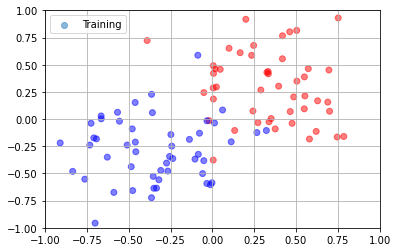

In [11]:
X, y = generateBatchBipolar(N, mu=0.3, sigma=0.3)
plotSvm(X, y, label='Training')

In [12]:
model = SoftMarginClassifier(C=1)
model.fit(X, y)
model.w, model.intercept

(array([2.48442074, 2.16746178]), -0.029141450396929065)

Number of support vectors = 31


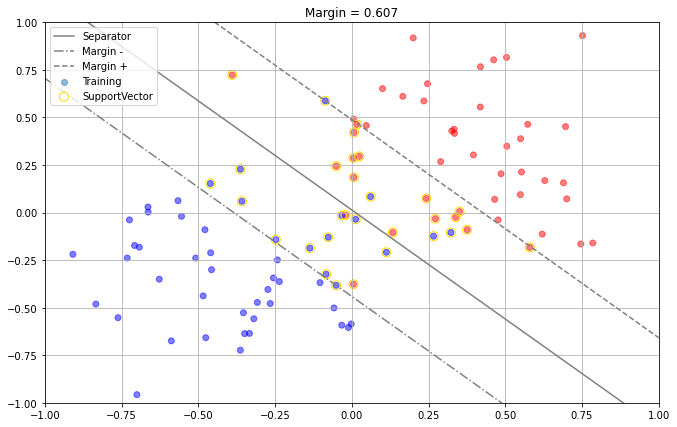

In [13]:
fig, ax = plt.subplots(1, figsize=(11, 7))
plotSvm(X, y, model.supportVectors, model.w, model.intercept, label='Training', ax=ax)

## Training the model using sklearn.svm.SVC

In [14]:
SKmodel = svm.SVC(kernel='linear', gamma='auto', C = 1)
SKmodel.fit(X, y)
SKmodel.coef_[0], SKmodel.intercept_[0]

(array([2.48357251, 2.1665817 ]), -0.04379669486334913)

Number of support vectors = 31


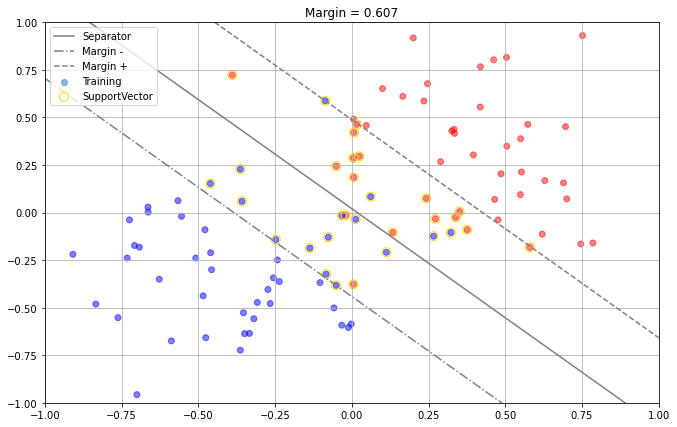

In [15]:
fig, ax = plt.subplots(1, figsize=(11, 7))
plotSvm(X, y, SKmodel.support_vectors_, SKmodel.coef_[0], SKmodel.intercept_[0], 
        label='Training', ax=ax)

## Introducing the Kernel trick

When using linear separators like the regression, the traditional way to deal with non linear functions is to expand the feature space using powers and products of the initial features. This is also necessary in case of multiclass problems. But there are limits to this trick and sometimes it's hard to know what features to use.

_SVM_ has used a new method known as the _Kernel trick_.

Let's apply a transformation to $x$ using function $h(x)$. 

The Lagrange dual problem becomes : 
$$\begin{align}
\mathcal{L}_d (\alpha)
&= \sum_{i=1}^n \alpha_i - \frac 12 \sum_{i=1}^n \sum_{j=1}^n \alpha_i \alpha_j y_i y_j h(x_i)^T h(x_j) \\
&= \sum_{i=1}^n \alpha_i - \frac 12 \sum_{i=1}^n \sum_{j=1}^n \alpha_i \alpha_j \langle y_i h(x_i), y_j h(x_j) \rangle \tag{14}\\
\end{align}$$

__S.t. :__ 
$\forall i\in 1..n$
- $0 \le \alpha_i \le C$
- $\sum_{i=0}^n \alpha_i y_i = 0$

Since $ w = \sum_{i=1}^n \alpha_i y_i h(x_i)$, the prediction function will be : 
$$ f(x) = sign(w^T h(x) + b) = sign \left(\sum_{i=1}^n \alpha_i y_i \langle h(x_i), h(x) \rangle + b \right) $$

Both the fit and prediction are based on the inner product $K(x, x') = \langle h(x), h(x') \rangle$, also known as the kernel function. This function shall be symmetric, semi-definite.

One of the most used kernels is the Gaussian Radial Basis Function (G-RBF) : $K(x, x') = exp(- \frac{\Vert x - x' \Vert^2}{2\sigma^2} )$

In [16]:
class KernelSvmClassifier:
    
    def __init__(self, C, kernel, epsilon=1e-3):
        self.C = C
        self.kernel = kernel
        self.alpha = None
        self.supportVectors = None
        self.epsilon = epsilon
    
    def fit(self, X, y):
        N = len(y)
        # Gram matrix of y.h(x)
        hX = np.apply_along_axis(lambda x1 : np.apply_along_axis(lambda x2:  self.kernel(x1, x2), 1, X),
                                  1, X)   
        yp = y.reshape(-1, 1)
        GramyHX = np.matmul(yp, yp.T) * hX

        # Lagrange dual problem
        def Ld(G, alpha):
            return alpha.sum() - 0.5 * alpha.dot(alpha.dot(G)) #equation 14

        # Partial derivate of Ld on alpha
        def LdAlpha(G, alpha):
            return np.ones_like(alpha) - alpha.dot(G)
        
        
        ########
        # although something like L2 regularization was tested on this problem to 
        # reduce the number of support vectors needed, but it wasn't useful.
        # the implementation that was done is shown below:

        #def Ld(G, alpha, r=10.):
            #return alpha.sum() - 0.5 * alpha.dot(alpha.dot(G)) - r/2. * sum(alpha**2)

        #def LdAlpha(G, alpha, r=10.):
            #return np.ones_like(alpha) - alpha.dot(G) - r*alpha
        ########

        # Constraints on alpha:
        A = np.vstack((-np.eye(N), np.eye(N)))
        b = np.hstack((np.zeros(N), self.C * np.ones(N)))
        constraints = ({'type': 'eq',   'fun': lambda a: np.dot(a, y),     'jac': lambda a: y},
                       {'type': 'ineq', 'fun': lambda a: b - np.dot(A, a), 'jac': lambda a: -A})

        # Maximize by minimizing the opposite
        optRes = optimize.minimize(fun=lambda a: -Ld(GramyHX, a),
                                   x0=np.ones(N), 
                                   method='SLSQP', 
                                   jac=lambda a: -LdAlpha(GramyHX, a), 
                                   constraints=constraints)
        self.alpha = optRes.x
        epsilon = self.epsilon
        supportIndices = self.alpha > epsilon
        self.supportVectors = X[supportIndices]
        self.supportAlphaY = y[supportIndices] * self.alpha[supportIndices]
    
    def predict(self, X):
        """ Predict y values in {-1, 1} """
        def predict1(x):
            x1 = np.apply_along_axis(lambda s: self.kernel(s, x), 1, self.supportVectors)
            x2 = x1 * self.supportAlphaY
            return np.sum(x2)
        
        d = np.apply_along_axis(predict1, 1, X)
        return 2 * (d > 0) - 1

def GRBF(x1, x2,sigma=.1):
    diff = x1 - x2
    return np.exp(-np.linalg.norm(diff)**2 / (2.*np.linalg.norm(sigma)**2))

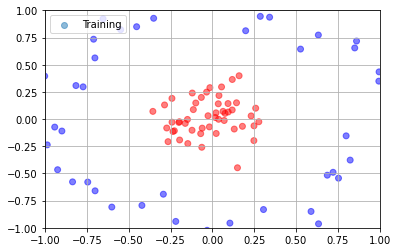

In [17]:
X, y = make_circles(N, factor=.2, noise=.1)
y = 2.*y - 1

plotSvm(X, y, label='Training')

In [18]:
modelK = KernelSvmClassifier(C=1., kernel=GRBF)
modelK.fit(X, y)

Number of support vectors = 72


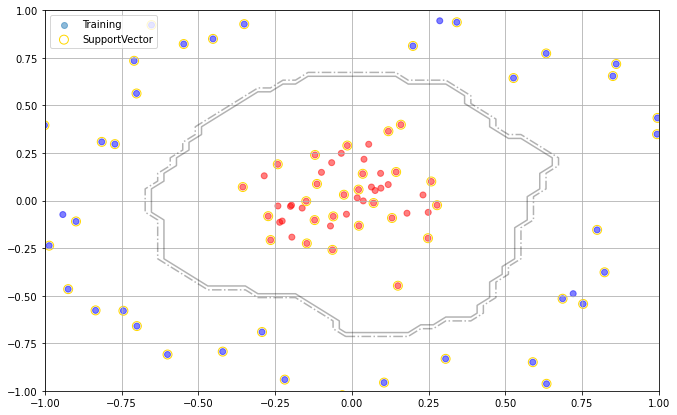

In [19]:
fig, ax = plt.subplots(1, figsize=(11, 7))
plotSvm(X, y, modelK.supportVectors, label='Training', ax=ax)

# Estimate and plot decision boundary
xx = np.linspace(-1, 1, 50)
X0, X1 = np.meshgrid(xx, xx)
xy = np.vstack([X0.ravel(), X1.ravel()]).T
Y30 = modelK.predict(xy).reshape(X0.shape)
ax.contour(X0, X1, Y30, colors='k', levels=[-1, 0], alpha=0.3, linestyles=['-.', '-']);

## Conclusion
We have shown the power of SVM classifiers for non linearly separable problems. From the end of the 1990's, SVM was the leading machine learning algorithm family for many problems. This situation has changed a little since 2010 as deep learning has shown better performance for some classes of problems. However, SVM remains stronger in many contexts and it is highly preferred by many as it produces significant accuracy with less computation power.